## Natural Language Processing with Disaster Tweets
##### Authors: Ruth Ashford, Toby Petty and Li Jin
This report is based on a Kaggle competition: https://www.kaggle.com/c/nlp-getting-started/data

The aim is to classify tweets as being about a disaster or not. We are given a labelled training data set a long with a unlabelled test data set. 

In the report, we perform initial EDA on the data, cleaning and processing of the tweets text and evaluate the performance Naive Bayes, Neural Network and Logistic Regression models.

In [1]:
import numpy as np
import os
import pandas as pd
pd.set_option("display.max_colwidth", 500)

data_fp = os.path.join(os.getcwd(), "data")
train_fp = os.path.join(data_fp, "train.csv")
train_full = pd.read_csv(train_fp, encoding="utf-8")
test_fp = os.path.join(data_fp, "test.csv")
test = pd.read_csv(test_fp, encoding="utf-8")

print(f"Train: {train_full.shape}")
print(f"Test:  {test.shape}")

train_full.head()

Train: (7613, 5)
Test:  (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


Kaggle supplies the test set (without target labels), so we will submit our final predictions there to get the ultimate measure of model performance.

## Exploratory data analysis


Firstly we will check the number of samples that are labelled as disaster (1) and non-disaster (0)

In [2]:
train_label_summary = train_full.groupby('target').agg(Total = ('id','count'))
train_label_summary['Percentage'] = round(train_label_summary['Total'] / train_full.shape[0] * 100, 1)
train_label_summary

,Total,Percentage
target,,
0,4342,57.0
1,3271,43.0


This shows us that we have a fairly even split of disaster and non-disaster labelled samples. This is useful when training our model but tell us that this data set is not likely to be representative of the general population of tweets, we know in general there are far less than 43% of tweets that are about disasters.

### Keywords
Next we want to take a look at the keywords and how they relate to the target. The majority of tweets in our training data have a keyword associated with them, there is just 0.2% of samples that don't.

In [3]:
keyword_label_summary = train_full.groupby('keyword').agg(percentage_disaster_occurance = ('target', 'mean')).reset_index()

keyword_disaster_count = train_full[train_full['target'] == 1].groupby('keyword').agg(disaster_count = ('target', 'count')).reset_index()
keyword_not_disaster_count = train_full[train_full['target'] == 0].groupby('keyword').agg(not_disaster_count = ('target', 'count')).reset_index()

keyword_label_summary = keyword_label_summary.merge(keyword_disaster_count, how='left')
keyword_label_summary = keyword_label_summary.merge(keyword_not_disaster_count, how='left')

print(f' Percentage of tweets without a keyword: {round(1 - train_full.keyword.isna().sum() / train_full.shape[0] * 100 , 2)}%')

 Percentage of tweets without a keyword: 0.2%


Below are the words that come up most often in disaster tweets.

In [4]:
keyword_label_summary.sort_values('percentage_disaster_occurance', 
                                  ascending=False).head(20)

,keyword,percentage_disaster_occurance,disaster_count,not_disaster_count
62,debris,1.000000,37.0,NaN
219,wreckage,1.000000,39.0,NaN
70,derailment,1.000000,39.0,NaN
153,outbreak,0.975000,39.0,1.0
152,oil%20spill,0.973684,37.0,1.0
205,typhoon,0.973684,37.0,1.0
187,suicide%20bombing,0.969697,32.0,1.0
186,suicide%20bomber,0.967742,30.0,1.0
32,bombing,0.931034,27.0,2.0
166,rescuers,0.914286,32.0,3.0


Below are the kewords that come up most often in non-disaster tweets. I can see that 'body%20bags' and body%20bag' is a duplicate and needs cleaning up. There are a lot of words here that I would associate with disasters, such as 'ruin', 'explode' and 'wrecked' but these are also words that could be used in a sentence when not describing a disaster.

In [5]:
keyword_label_summary.sort_values('percentage_disaster_occurance', 
                                  ascending=True).head(20)

,keyword,percentage_disaster_occurance,disaster_count,not_disaster_count
2,aftershock,0.000000,NaN,34.0
29,body%20bags,0.024390,1.0,40.0
170,ruin,0.027027,1.0,36.0
19,blazing,0.029412,1.0,33.0
27,body%20bag,0.030303,1.0,32.0
88,electrocute,0.031250,1.0,31.0
173,screaming,0.055556,2.0,34.0
201,traumatised,0.057143,2.0,33.0
156,panicking,0.060606,2.0,31.0
21,blew%20up,0.060606,2.0,31.0


### Length of tweets
We want to understand if the length of the tweet differs for disaster tweets versus non-disaster tweets

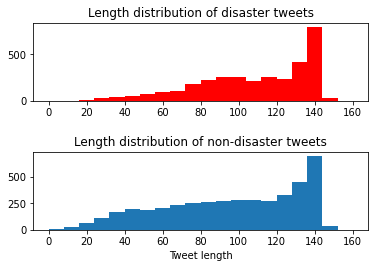

Average length of disaster tweets is 108 with standard deviation 29
Average length of non-disaster tweets is 96 with standard deviation 36


In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
fig. tight_layout(pad=3.0)

disaster_length = train_full[train_full['target'] == 1]['text'].apply(lambda x: len(x))
non_disaster_length = train_full[train_full['target'] == 0]['text'].apply(lambda x: len(x))

axs[0].hist(x = disaster_length, color='red', bins=20, range = (0,160))
axs[0].set_title('Length distribution of disaster tweets')
axs[1].hist(x = non_disaster_length, bins=20, range = (0,160))
axs[1].set_title('Length distribution of non-disaster tweets')
axs[1].set_xlabel('Tweet length')

plt.show()

print(f'Average length of disaster tweets is {round(disaster_length.mean())} ' \
 f'with standard deviation {round(disaster_length.std())}')

print(f'Average length of non-disaster tweets is {round(non_disaster_length.mean())} ' \
 f'with standard deviation {round(non_disaster_length.std())}')


We can see that the do seem to be slightly longer, but not by a huge amount.

### Number of words
Similarily, we want to understand if there are any key differences in the number of words in the tweets.

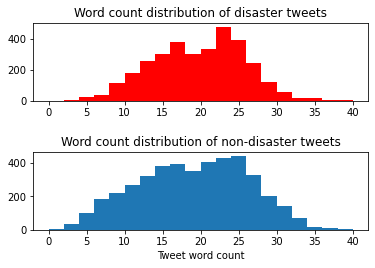

Average length of disaster tweets is 19 with standard deviation 6
Average length of non-disaster tweets is 19 with standard deviation 7


In [7]:
from nltk.tokenize import word_tokenize

fig, axs = plt.subplots(2)
fig. tight_layout(pad=3.0)

disaster_wc = train_full[train_full['target'] == 1]['text'].apply(lambda x: len(word_tokenize(x)))
non_disaster_wc = train_full[train_full['target'] == 0]['text'].apply(lambda x: len(word_tokenize(x)))

axs[0].hist(x = disaster_wc, color='red', bins=20, range = (0,40))
axs[0].set_title('Word count distribution of disaster tweets')
axs[1].hist(x = non_disaster_wc, bins=20, range = (0,40))
axs[1].set_title('Word count distribution of non-disaster tweets')
axs[1].set_xlabel('Tweet word count')

plt.show()

print(f'Average length of disaster tweets is {round(disaster_wc.mean())} ' \
 f'with standard deviation {round(disaster_wc.std())}')

print(f'Average length of non-disaster tweets is {round(non_disaster_wc.mean())} ' \
 f'with standard deviation {round(non_disaster_wc.std())}')

Again, no real difference here between disaster and non-disaster tweets.

### Location

Location data is provided for 65% of the samples. The location data seems to range from being as broad as a country, or as specific as the name of a restaurant.

In [8]:
print(f' Percentage of tweets without a location: ' + 
      f'{round((1 - train_full.location.isna().sum() / train_full.shape[0]) * 100 , 2)}%')

pd.DataFrame(train_full.location.unique())

 Percentage of tweets without a location: 66.73%


,0
0,NaN
1,Birmingham
2,Est. September 2012 - Bristol
3,AFRICA
4,"Philadelphia, PA"
...,...
3337,TN
3338,#NewcastleuponTyne #UK
3339,"Vancouver, Canada"
3340,London


### Baseline model

We use CountVectorizer and BernoulliNB to create a baseline model, and get benchmark score against the validation set.

Note that the target labels are binary outcomes, so they comrpise a Bernoulli distribution where  𝑝≈0.43 . Therefore accuracy is the chosen metric of performance, since there isn't a huge class imbalance.

### Training and validation data
We will reserve 20% of the training data set as a validation data set to test iterations of the model against.

In [9]:
# Shuffle the index in case there are patterns in the order of the training data:
np.random.seed(42)
shuffled_ix = list(train_full.index)
np.random.shuffle(shuffled_ix)
cutoff = int(len(shuffled_ix)*0.8)
train = train_full.loc[shuffled_ix[:cutoff]].copy()
validation = train_full.loc[shuffled_ix[cutoff:]].copy()

print(f'Train data set contains {train.shape[0]} samples')
print(f'Validation data set contains {validation.shape[0]} samples')

Train data set contains 6090 samples
Validation data set contains 1523 samples


In [10]:
train_data = train["text"]
train_labels = train["target"]
validation_data = validation["text"]
validation_labels = validation["target"]

In [11]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

### Assessing the baseline model

Bernoulli distribution, p = 0.430
Validation f1 score = 0.784


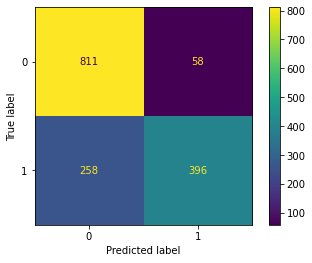

In [12]:
vec = CountVectorizer()
vec.fit(train_data)
train_vec = vec.transform(train_data)

print(f"Bernoulli distribution, p = {train_labels.mean():.3f}")

model = BernoulliNB()
crossval = cross_validate(model, train_vec, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
validation_vec = vec.transform(validation_data)
pred = best_estimator.predict(validation_vec)
validation_score = f1_score(validation_labels, pred, average='weighted')
print(f"Validation f1 score = {validation_score:.3f}")

cm = plot_confusion_matrix(best_estimator, validation_vec, validation_labels)

The baseline gives us an f1 score on the validation data set of 0.784, we can see from the confusion matrix that there are a lot of false negatives.

In [13]:
def false_negatives(labels, preds, original_data, processed_data):
    df = pd.DataFrame()
    df['original_data'] = original_data
    df['processed_data'] = processed_data
    df['label'] = labels
    df['prediction'] = preds
    return df[(df["label"] == 1) & (df["prediction"] == 0)]

In [14]:
def false_positives(labels, preds, original_data, processed_data):
    df = pd.DataFrame()
    df['original_data'] = original_data
    df['processed_data'] = processed_data
    df['label'] = labels
    df['prediction'] = pred
    return df[(df["label"] == 0) & (df["prediction"] == 1)]

In [15]:
false_negatives(validation_labels, pred, validation_data, 
                validation_data)['processed_data'].to_frame()[:10]

,processed_data
1279,Burned dog finds new home with young burn victim http://t.co/Pqrjvgvgxg
6883,@PyramidHead76 one good thing came out of watching the film. Was too traumatised to watch show so started Halt &amp; Catch Fire on Amazon. :D
7138,@MrMikeEaton @Muazimus_Prime hill hill mountain volcano of hell mountain hill hil.
3156,Gonna call up tomorrow with the aul 'emergency dental appointment' excuse just like the whole tooth falling out incident of last year
5207,@TheEvilOlives It's the closest structure to the hypo centre that wasn't completely obliterated.
3310,Sooo police dispatch said there was a person threatening to shoot up the Walmart on Rutherford &amp; they had to evacuate
3462,oh yeah my ipod almost exploded last night i was using it while charging and shit was sparking akxbskdn almost died
2161,Bigamist and his 'first' wife are charged in the deaths of his 'second' pregnant wife her child 8 her mothe... http://t.co/rTEuGB5Tnv
285,And so it begins.. day one of the snow apocalypse
4524,@Hurricane_Dolce no prob


In the false positives there are a lot of hyperlinks, punctuation and @ symbols that can be cleaned up.

## Model 1 - Naive Bayes

We will clean the data up and use stemming an lematization to see if we can improve upon the baseline Naive Bayes model.

In [16]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('punkt')
nltk.download('wordnet')
stemmer = PorterStemmer()
lemmer = WordNetLemmatizer()

def stem_sentence(text):
    token_words=word_tokenize(text)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(stemmer.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def lem_sentence(text):
    token_words=word_tokenize(text)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lemmer.lemmatize(word, pos='n'))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r"(?:\@)\w+", ' ', text)
    text = re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~?!]+',' ',text)
    text = re.sub(r"[']+",'',text)
    
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    
    text=text.encode("ascii",errors="ignore").decode()

    return text

def clean_and_lem(text):
    return lem_sentence(clean_text(text))

def clean_and_stem(text):
    return stem_sentence(clean_text(text))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/icexelloss/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/icexelloss/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Clean tweets text
We clean the text to try to remove anything that adds noise, for example hyperlinks. 
In addition to this we've added Laplace smoothing to the model (alpha parameter)

In [17]:
vec = CountVectorizer(analyzer='word', preprocessor=clean_text)
vec.fit(train_data)
train_vec = vec.transform(train_data)

model = BernoulliNB(alpha=0.85)
crossval = cross_validate(model, train_vec, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
validation_vec = vec.transform(validation_data)
pred = best_estimator.predict(validation_vec)
validation_score = f1_score(validation_labels, pred, average='weighted')
print(f"Validation f1 score = {validation_score:.3f}")

Validation f1 score = 0.797


Cleaning the data has improved the f1 score on the validation data set to 0.797

### Stemming
We use the Porter stemmer to normalize words in the tweets. A stemming algorithm reduces a word to it's root, for example “retrieval”, “retrieved”, “retrieves” reduce to the stem “retrieve”.

In [18]:
vec = CountVectorizer(analyzer='word', preprocessor=clean_and_stem)
vec.fit(train_data)
train_vec = vec.transform(train_data)

model = BernoulliNB(alpha=0.85)
crossval = cross_validate(model, train_vec, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
validation_vec = vec.transform(validation_data)
pred = best_estimator.predict(validation_vec)
validation_score = f1_score(validation_labels, pred, average='weighted')
print(f"Validation f1 score = {validation_score:.3f}")

Validation f1 score = 0.796


Applying stemming to the data after cleaning it has reduced the accuracy of the model slightly, this may be due to overstemming where two words of different meaning are reduced to the same stem.

### Lemmatization
Lemmatization is similar to stemming but it converts a word to it's base form while also taking into account the context of the words. For example using lemmatization, 'caring' gets converted to 'care', whereas when using a stemmer, it will likely get converted to 'car'.

In [19]:
vec = CountVectorizer(analyzer='word', preprocessor=clean_and_lem)
vec.fit(train_data)
train_vec = vec.transform(train_data)

model = BernoulliNB(alpha=0.75)
crossval = cross_validate(model, train_vec, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score:.3f}")
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
validation_vec = vec.transform(validation_data)
pred = best_estimator.predict(validation_vec)
validation_score = f1_score(validation_labels, pred, average='weighted')
print(f"Validation f1 score = {validation_score:.3f}")

Mean accuracy on 5-fold cross validation = 0.802
Validation f1 score = 0.802


Lemmatizing has been more successful and has increased the validation f1 score to 0.802

### Term Frequency - Inverse Document Frequency 
TFIDF is based on the same bag of words technique as Count Vectorizer but it considers how important the word is. It does this by determining how rare the word is by diving the number of times is appears in the document by the number of times it appears in any document.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(preprocessor=clean_and_lem, encoding='utf-8',
                       ngram_range=(1,1),
                       max_features=11000, 
                       norm='l2'
                    )
vec.fit(train_data)
train_vec = vec.transform(train_data)

model = BernoulliNB(alpha=0.75)
crossval = cross_validate(model, train_vec, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score:.3f}")
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
validation_vec = vec.transform(validation_data)
pred = best_estimator.predict(validation_vec)
validation_score = f1_score(validation_labels, pred, average='weighted')
print(f"Validation f1 score = {validation_score:.3f}")

Mean accuracy on 5-fold cross validation = 0.803
Validation f1 score = 0.801


In [21]:
false_negatives(validation_labels, pred, validation_data, 
                validation_data.apply(lambda x: clean_and_lem(x)))[['original_data', 'processed_data']][:20]

,original_data,processed_data
1279,Burned dog finds new home with young burn victim http://t.co/Pqrjvgvgxg,burned dog find new home with young burn victim
6883,@PyramidHead76 one good thing came out of watching the film. Was too traumatised to watch show so started Halt &amp; Catch Fire on Amazon. :D,one good thing came out of watching the film wa too traumatised to watch show so started halt amp catch fire on amazon d
7138,@MrMikeEaton @Muazimus_Prime hill hill mountain volcano of hell mountain hill hil.,hill hill mountain volcano of hell mountain hill hil
3156,Gonna call up tomorrow with the aul 'emergency dental appointment' excuse just like the whole tooth falling out incident of last year,gon na call up tomorrow with the aul emergency dental appointment excuse just like the whole tooth falling out incident of last year
5207,@TheEvilOlives It's the closest structure to the hypo centre that wasn't completely obliterated.,it the closest structure to the hypo centre that wasnt completely obliterated
3462,oh yeah my ipod almost exploded last night i was using it while charging and shit was sparking akxbskdn almost died,oh yeah my ipod almost exploded last night i wa using it while charging and shit wa sparking akxbskdn almost died
2161,Bigamist and his 'first' wife are charged in the deaths of his 'second' pregnant wife her child 8 her mothe... http://t.co/rTEuGB5Tnv,bigamist and his first wife are charged in the death of his second pregnant wife her child 8 her mothe
285,And so it begins.. day one of the snow apocalypse,and so it begin day one of the snow apocalypse
4524,@Hurricane_Dolce no prob,no prob
6771,Maybe that's what happens when a tornado meets a volcano,maybe thats what happens when a tornado meet a volcano


It's interesting to see a lot of the tweets here that were originally labelled as disasters don't seem to be about disasters, so when examining these it seems like our model may be correctly classifying them as non-disaster tweets. We'll get predictions for the test data set provided by Kaggle using this model and see how it performs.

### Assessing using the test data set


In [22]:
test_vec = vec.transform(test['text'])
test_preds = best_estimator.predict(test_vec)
nb_submission = pd.DataFrame({'id': test.id, 'target': test_preds})
#np.savetxt("naive_bayes_test_predictions.csv", test_preds, delimiter=",", header="target", 
      #     fmt="%i")
nb_submission.to_csv('naive_bayes_test_predictions.csv', index=False)

This submission gave us a Kaggle score of 0.79313

## Model 2 - Logistic Regression

In this section, we will introduce our second model using Logistic Regression and analysis the result. This section will use the same preprocessing as the previous model.

### Model and Performance

In [23]:
model = LogisticRegression()
model.fit(train_vec, train_labels)
pred = model.predict(validation_vec)

crossval = cross_validate(model, train_vec, train_labels, cv=5, return_estimator=True)
mean_score = crossval["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score:.3f}")
best_estimator = crossval["estimator"][crossval["test_score"].argmax()]
validation_vec = vec.transform(validation_data)
pred = best_estimator.predict(validation_vec)
validation_score = f1_score(validation_labels, pred, average='weighted')
print(f"Validation f1 score = {validation_score:.3f}")

Mean accuracy on 5-fold cross validation = 0.807
Validation f1 score = 0.782


The score is a little worse than Model 1. Next we will do some error analysis.

### Error Analysis

####  Top Coefficients

First we look at highest coefficients to see if that makes sense.

In [24]:
feature_index = np.argsort(-model.coef_)[:, :100].flatten()

vocabulary_df = pd.DataFrame({
    'text': vec.vocabulary_.keys(),
    'feature': vec.vocabulary_.values()
}).set_index('feature')

df = pd.DataFrame(model.coef_[:, feature_index]).T
df.index = vocabulary_df.loc[feature_index]
df.columns = ['positive']

print("Table of top 50 features and their coefficients")
print(df.iloc[:50])

Table of top 50 features and their coefficients
                positive
(fire,)         3.810866
(in,)           3.343749
(hiroshima,)    3.085050
(train,)        2.900931
(california,)   2.779010
(storm,)        2.644719
(wildfire,)     2.558687
(bombing,)      2.469046
(flood,)        2.427287
(suicide,)      2.357004
(disaster,)     2.262189
(near,)         2.096496
(police,)       2.037451
(building,)     1.990621
(murder,)       1.962556
(at,)           1.849177
(over,)         1.842410
(typhoon,)      1.841772
(mass,)         1.828538
(after,)        1.816829
(war,)          1.811453
(japan,)        1.800284
(derailment,)   1.797760
(drought,)      1.795589
(warning,)      1.792510
(crash,)        1.783022
(terrorist,)    1.726204
(earthquake,)   1.721908
(collapse,)     1.709789
(debris,)       1.703589
(car,)          1.698958
(killed,)       1.696351
(massacre,)     1.684230
(tornado,)      1.667455
(mh370,)        1.660156
(nuclear,)      1.648894
(during,)       1.638216
(h

At a glance the coefficients are a mixture of 
* indicator of a disaster (wildfire, hailstorm, earthquake, ...) 
* words that can be related to a disaster (catastrophic, police, severe, ...)
* Neutral word (airport, coach, gas, near, ...)

which seem to make sense.

### False Negatives

In [25]:
false_negatives(validation_labels, pred, validation_data, 
                validation_data.apply(lambda x: clean_and_lem(x)))[['original_data', 'processed_data']][:20]

,original_data,processed_data
1279,Burned dog finds new home with young burn victim http://t.co/Pqrjvgvgxg,burned dog find new home with young burn victim
6883,@PyramidHead76 one good thing came out of watching the film. Was too traumatised to watch show so started Halt &amp; Catch Fire on Amazon. :D,one good thing came out of watching the film wa too traumatised to watch show so started halt amp catch fire on amazon d
7138,@MrMikeEaton @Muazimus_Prime hill hill mountain volcano of hell mountain hill hil.,hill hill mountain volcano of hell mountain hill hil
3156,Gonna call up tomorrow with the aul 'emergency dental appointment' excuse just like the whole tooth falling out incident of last year,gon na call up tomorrow with the aul emergency dental appointment excuse just like the whole tooth falling out incident of last year
5207,@TheEvilOlives It's the closest structure to the hypo centre that wasn't completely obliterated.,it the closest structure to the hypo centre that wasnt completely obliterated
3462,oh yeah my ipod almost exploded last night i was using it while charging and shit was sparking akxbskdn almost died,oh yeah my ipod almost exploded last night i wa using it while charging and shit wa sparking akxbskdn almost died
4895,Headed to the massacre \nBodies arriving everyday \nWhat were those shells you heard \nPicking the bones up along the way,headed to the massacre body arriving everyday what were those shell you heard picking the bone up along the way
2161,Bigamist and his 'first' wife are charged in the deaths of his 'second' pregnant wife her child 8 her mothe... http://t.co/rTEuGB5Tnv,bigamist and his first wife are charged in the death of his second pregnant wife her child 8 her mothe
285,And so it begins.. day one of the snow apocalypse,and so it begin day one of the snow apocalypse
4524,@Hurricane_Dolce no prob,no prob



Looking at false negatives, it appears that some of the test labels can be wrong. For example, these tweets are clearly not disasters but is labeled as so:
* but if you build an army of 100 dogs and their leader is a lion all dogs will fight like a lion
* watch these super strong magnets destroy everyday objects
* check out my lava lamp dude   
* ...

These wrong labels can explain why recall for positive is quite low.

### False positives

In [26]:
false_positives(validation_labels, pred, validation_data, 
                validation_data.apply(lambda x: clean_and_lem(x)))[['original_data', 'processed_data']][:20]

,original_data,processed_data
3190,Practice your families fire escape plan so everyone knows what to do in case of an emergency.,practice your family fire escape plan so everyone know what to do in case of an emergency
3594,The Five Fatal Flaws in the Iran Deal https://t.co/ztfEAd8GId via @YouTube,the five fatal flaw in the iran deal
1308,RT @HuffPostComedy: We should build a wall that keeps Burning Man attendees from coming home http://t.co/xwVW1sft4I http://t.co/j7HUKhWmal,rt we should build a wall that keep burning man attendee from coming home
6097,?that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time,that horrible sinking feeling when youve been at home on your phone for a while and you realise it been on 3g this whole time
5619,Newlyweds feed Syrian refugees at their wedding - CBC News - Latest Canada World Entertainment and Business News http://t.co/QU8S89pVVt,newlywed feed syrian refugee at their wedding cbc news latest canada world entertainment and business news
7159,Camping in a war zone with roving raccoons toughens city slicker http://t.co/oJuS08yZrq,camping in a war zone with roving raccoon toughens city slicker
6103,that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time,that horrible sinking feeling when youve been at home on your phone for a while and you realise it been on 3g this whole time
4873,@BenignoVito @LibertyBell1000 HILLARYMASS MURDERER.,hillarymass murderer
5083,Nuclear deal disaster.\n\n#IranDeal #NoNuclearIran #BadIranDeal @JebBush @BarackObama http://t.co/z7phPjtqud,nuclear deal disaster irandeal nonucleariran badirandeal
3057,#Sismo M 1.3 - 1km NNE of The Geysers California: Time2015-08-05 23:40:21 UTC2015-08-05 16:40:21 -07:00 a... http://t.co/x6el3ySYcn #CS,sismo m 1 3 1km nne of the geyser california time2015 08 05 23 40 21 utc2015 08 05 16 40 21 07 00 a


Looking at false positives, some of the tweets are very hard for this model to detect, e.g:

* battlefield 4 funny moments   dukes of hazard undercover soldier mav t  (video game)
* shes a suicide bomb (metaphor)

Some of the false positives are possibily due to the bags of word approach itself:

* advice from noah  dont go running in a thunderstorm

Some of the false postives might get better two a bigram approach:
* the government is concerned about the population explosion and the population is concerned about the government explosion    joe moore (population explosion)
* pizza drought is over i just couldnt anymore (pizza drought)

### Bigram
Finally, we try to use bigram and see how it performs.

In [27]:
# Warning, run this cell will change tra
vec_2 = TfidfVectorizer(
    preprocessor=clean_and_lem, encoding='utf-8',
    ngram_range=(2, 2),
    norm='l2'
)
train_vec_2 = vec_2.fit_transform(train_data)
validation_vec_2 = vec_2.transform(validation_data)

model_2 = LogisticRegression()
model_2.fit(train_vec_2, train_labels)
pred_2 = model_2.predict(validation_vec_2)

crossval_2 = cross_validate(model_2, train_vec_2, train_labels, cv=5, return_estimator=True)
mean_score_2 = crossval_2["test_score"].mean()
print(f"Mean accuracy on 5-fold cross validation = {mean_score_2:.3f}")
best_estimator_2 = crossval_2["estimator"][crossval_2["test_score"].argmax()]
pred_2 = best_estimator_2.predict(validation_vec_2)
validation_score = f1_score(validation_labels, pred_2, average='weighted')
print(f"Validation f1 score = {validation_score:.3f}")

Mean accuracy on 5-fold cross validation = 0.705
Validation f1 score = 0.709


Unfortunately, using bigram results in a worse performance. Therefore we will stick to unigram.

### Assessing using the test data set¶

In [28]:
test_vec = vec.transform(test['text'])
test_preds = best_estimator.predict(test_vec)
nb_submission = pd.DataFrame({'id': test.id, 'target': test_preds})
nb_submission.to_csv('logistic_regression_test_predictions.csv', index=False)

This gives us a final score of 0.78945.

## Model 3 - Neural Network

The final approach we try is to use a different representation of text data as word embeddings, and to train a Neural Network model to classify the tweets based on numeric vector inputs created from these word embeddings.

### GloVe Word Embeddings

The word embeddings scheme chosen is a pretrained GloVe model with ~1.2m word vocabulary, trained on ~2 billion tweets. It is hoped that by using a word embeddings scheme trained on tweets, it will perform well on our dataset which is also scraped from Twitter.

In [29]:
from gensim import downloader  # Library which supplies the word embeddings.

# Load the pretrained word embeddings (this takes a while):
glove_twitter = downloader.load("glove-twitter-200")
info = downloader.info()
print(info["models"]["glove-twitter-200"]["description"])

ModuleNotFoundError: No module named 'gensim'

### Pre-Processing

The creators of the particular word embeddings scheme chosen also released a <a href="https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb">Ruby script</a> to apply the same text transformations to tweet data that they used when creating the embeddings. A user on Kaggle converted this script to <a href="https://www.kaggle.com/amackcrane/python-version-of-glove-twitter-preprocess-script">Python</a>, which we adapted below with some additional changes to improve the number of input words which can be embedded. Some of these changes include:

1. Removing most punctuation entirely. The original Kaggle script leaves a lot of punctation untouched, so that for example the quoted word `'something'` would be included as a separate feature to the unquoted word `something`. We make the assumption that such differences in punctuation of features are unlikely to be significant in identifying disaster tweets.
2. Fixing a couple of bugs with the way whitespace was added around certain punctuation marks, such as `.,`
3. Add spaces around inserted tags such as ` <number> `

Making the above changes to the preprocessor we increase the number of input words which are found in the embeddings vocabulary from ~75% to nearly 90%.

One interesting decision in the preprocessing script is to remove tagged twitter usernames (i.e. strings starting with `@`), since we might expect that this could provide some useful information in trying to predict the nature of the tweets. For example, a tweet tagging a local fire department might be much more likely to be a disaster related tweet. However since we are using a pretrained embeddings scheme we don't have the option to include usernames.

In [ ]:

import string
import sys
import regex as re

FLAGS = re.MULTILINE | re.DOTALL


punctuation = string.punctuation.replace("#", "")
punctuation = punctuation.replace("<", "")
punctuation = punctuation.replace(">", "")


def _hashtag(text):
    """Parse hashtags in tweets.
    
    For hashtags with words in title case, splits into separate words, e.g.
        #BigFire -> <hashtag> Big Fire 
        
    For all caps hashtags converts to lowercase, e.g.
        #OMG -> <hashtag> omg
    """
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = f" <hashtag> {hashtag_body.lower()} <allcaps> "
    else:
        result = " ".join([" <hashtag> "] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result


def _allcaps(text):
    """Convert all-caps words to lowercase and add allcaps tag."""
    text = text.group()
    return text.lower() + " <allcaps> "


def tokenize(text):
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    # Remove URLS:
    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", " <url> ")
    
    # Remove usernames:
    text = re_sub(r"@\w+", " <user> ")
    
    # Tag smiley faces :-) sad faces :-( etc.
    eyes, nose = r"[8:=;]", r"['`\-]?"
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), " <smile> ")
    text = re_sub(r"{}{}p+".format(eyes, nose), " <lolface> ")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), " <sadface> ")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), " <neutralface> ")
    text = re_sub(r"<3"," <heart> ")

    # Add whitespace around /
    text = re_sub(r"/"," / ")
    
    # Tag numbers:
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", " <number> ")
    
    # Tag hastags and separate hashtag words:
    text = re_sub(r"#\w+", _hashtag)
    
    # Remove and tag repetitions of question marks, exclamations:
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat> ")
    
    # Tag elongated sequences of the same letter (3+ occurences), e.g. "AAAAAAA"
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong> ")
    
    # Put whitespace around punctuation, then remove:
    text = re_sub(r"([a-zA-Z<>()])([{}])".format(punctuation), r"\1 \2")
    text = re_sub(r"([{}])([a-zA-Z<>()])".format(punctuation), r"\1 \2")
    text = re.sub("[%s]" % re.escape(punctuation), "", text)

    # Tag all caps words:
    text = re_sub(r" ([A-Z]){2,} ", _allcaps)
    
    return " ".join(text.lower().split())


In [ ]:
# Fake example with lots of weird features:
text = "#BigFire on #MountEverest #OMG, !! /where are police 'some' punctuation! 3now 44 @police"
tokenize(text)

In [ ]:
# Example from the dataset:
example_tweet = train["text"][0]
print("Original Tweet:\n", f"  {example_tweet}\n")
print("After preprocessing script:\n", f"{tokenize(example_tweet)}\n")

### Applying the Word Embeddings

The pretrained word embeddings convert each word in a processed tweet (which is in its vocabulary) to a $d$-length vector. Because the Neural Network requires a single vector input, we need a way to convert the multiple word embeddings for a single tweet into one vector. Using a suggestion <a href="https://stats.stackexchange.com/a/239071/115143">here</a>, we try 2 approaches:

1. Take the simple average of the vectors for all words in the tweet (resulting in vector of length $d$).
2. Concatenate the coordinate-wise minimum and maximum values in each word vector (resulting in vector of length $2d$).

In addition to applying the preprocessor, we also add a method to correct common spelling mistakes, which through experimentation improves model performance and allows us to find word embeddings for more than 90% of the input words.

In [ ]:

from gensim.models.keyedvectors import KeyedVectors
from spellchecker import SpellChecker
import yaml


class WordEmbeddings:
    """Class to create word embeddings from input tweets, 
    including text pre-processing."""
    
    def __init__(self, X: pd.Series, embeddings: KeyedVectors, 
                 processor = tokenize, spellcheck: bool = True):
        """Takes input tweets, preprocesses them, and converts them 
        to the 2 different word embedding representations.
        
        Args:
            X: input unprocessed tweets.
            embeddings: word embeddings scheme from gensim.
            processor: method for preprocessing tweets.
            spellcheck: if True, use spellchecker package to correct common
                spelling mistakes in input tweets before preprocessing.
                
        """
        # Save the raw input as a list:
        self.X_raw = X.tolist()
        
        # Apply the preprocessor function:
        X = X.map(processor).tolist()
        
        # Apply the spelling corrections:
        if spellcheck:
            corrections = self.correct_spellings([])
            corrected = list()
            for tweet in X:
                corrected.append(" ".join([corrections.get(w, w) for w in tweet.split()]))
            X = corrected

        self.X = X
        
        # Store the word embeddings scheme:
        self.embeddings = embeddings
        
        # Unique vocabulary of the embedding scheme:
        self.embeddings_vocab = set(embeddings.key_to_index)
        
        # Unique vocabulary of the inputs:
        self.X_vocab = {w for words in [s.split() for s in X] for w in words}
        
        # Unknown words in the input:
        self.unknown_words = self.X_vocab - self.embeddings_vocab

        # Common vocabulary between the input and the embeddings scheme:
        self.common_vocab = self.embeddings_vocab & self.X_vocab
        self.vocab_coverage = len(self.common_vocab) / len(self.X_vocab)
        print(f"{len(self.X_vocab):} processed input words, "\
              f"{len(self.common_vocab):} found in embeddings "\
              f"({self.vocab_coverage*100:.2f}%).")

        # Lookup table from words to their embeddings:
        self.embeddings_table = pd.DataFrame(embeddings[self.common_vocab], index=self.common_vocab).sort_index()
        
        # Iterate through input tweets removing unknown words, creating average/min/max embeddings:
        embedding_mu, embedding_max, embedding_min, clean_tweets = list(), list(), list(), list()
        for i, tweet in enumerate(self.X):
            
            # Remove unknown words:
            words = tweet.split()
            known_words = [w for w in words if w in self.common_vocab]
            clean_tweets.append(" ".join(known_words))
            
            # Calculate mean of all word embeddings in tweet:
            mean_array = self.embeddings_table.loc[known_words].mean().values
            embedding_mu.append(mean_array)
            
            # Calculate min/max of all word embeddings in tweet:
            max_array = self.embeddings_table.loc[known_words].max().values
            embedding_max.append(max_array)
            min_array = self.embeddings_table.loc[known_words].min().values
            embedding_min.append(min_array)
            
        # Arrays of final X datasets in word embedding formats:
        self.embedding_mu = pd.DataFrame(np.array(embedding_mu))
        self.embedding_min = np.array(embedding_min)
        self.embedding_max = np.array(embedding_max)
        self.embedding_minmax = pd.DataFrame(np.concatenate([self.embedding_min, self.embedding_max], axis=1))
        
    @property
    def embedding_chars(self):
        """Unique characters in the word embeddings."""
        return "".join(sorted(set([c for w in self.embeddings.index_to_key for c in w])))
    
    @staticmethod
    def correct_spellings(words: list):
        """Use pyspellchecker to save a dictionary of unknown words
        to corrected spellings, or just load presaved corrections. 
        See:
            https://github.com/barrust/pyspellchecker
        """
        fp = os.path.join(os.getcwd(), "spelling_corrections.yaml")
        if not os.path.exists(fp):
            corrections = dict()
            with open(fp, "w") as stream:
                yaml.safe_dump(corrections, stream)
        else:
            with open(fp, "r") as stream:
                corrections = yaml.safe_load(stream)
            if corrections is None:
                corrections = dict()
        to_correct = [w for w in words if w not in corrections]
        if to_correct:
            spell = SpellChecker()
            new = {w: spell.correction(w) for w in to_correct}
            corrections = {**corrections, **new}
            with open(fp, "w") as stream:
                yaml.safe_dump(corrections, stream)
            print(f"Saved {len(new):} spelling corrections to file.")
        return corrections


In [ ]:
# Use the class to apply embeddings to the training & validation data:
train_we = WordEmbeddings(train["text"], glove_twitter)
validation_we = WordEmbeddings(validation["text"], glove_twitter)

### Neural Network

Using TensorFlow to train model with "early stopping" to prevent over-fitting:

In [ ]:

from sklearn.metrics import accuracy_score
import tensorflow as tf


class TfModel:
    
    def __init__(self, X_train: WordEmbeddings, y_train: pd.Series, 
                 X_val: WordEmbeddings, y_val: pd.Series, 
                 epochs: int = 500, patience: int = 5):
        """Implement a TensorFlow model on WordEmbeddings training and 
        validation data."""
        
        # Store model inputs:
        self.X_train, self.y_train = X_train, y_train
        self.X_val, self.y_val = X_val, y_val
                
        # Train separate models for different embeddings schemes:
        self.results, self.best_score, self.best_model = dict(), -np.inf, None
        for embeddings in ("embedding_mu", "embedding_minmax"):            
            print(f"Training {embeddings} model\n")
            
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dense(64, activation='relu'),
                tf.keras.layers.Dense(2)
            ])

            model.compile(
                optimizer="adam",
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"]
            )

            callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy", 
                mode="max", 
                min_delta=0.001,
                patience=patience, 
                restore_best_weights=True
            )
            
            X_train_df = getattr(X_train, embeddings)
            X_val_df = getattr(X_val, embeddings)
            history = model.fit(
                x=X_train_df,
                y=self.y_train,
                batch_size=512,
                callbacks=[callback],
                verbose=2,
                validation_data=(X_val_df, self.y_val),
                epochs=epochs,
            )

            # Use probabilities to make predictions on validation set:
            proba_model = tf.keras.Sequential([
                model, 
                tf.keras.layers.Softmax()
            ])
            train_proba_pred = proba_model.predict(X_train_df)
            val_proba_pred = proba_model.predict(X_val_df)
            train_pred = np.argmax(train_proba_pred, axis=1)
            val_pred = np.argmax(val_proba_pred, axis=1)
            
            # Store full results:
            results_data = {
                "model": model,
                "history": history,
                "proba_model": proba_model,
                "train_proba_pred": train_proba_pred,
                "val_proba_pred": val_proba_pred,
                "train_pred": train_pred,
                "val_pred": val_pred,
            }
            self.results[embeddings] = results_data
            
            # Score the model on overall accuracy on validation set:
            accuracy = accuracy_score(self.y_val, val_pred)
            if accuracy > self.best_score:
                self.best_score = accuracy
                self.best_model = embeddings
            print()
    
    @property
    def inspect_train(self):
        df = pd.DataFrame({
            "raw_tweet": self.X_train.X_raw,
            "processed_tweet": self.X_train.X,
            "true_label": self.y_train.values,
            "prediction": self.results[self.best_model]["train_pred"]
        })
        return df

    @property
    def inspect_val(self):
        df = pd.DataFrame({
            "raw_tweet": self.X_val.X_raw,
            "processed_tweet": self.X_val.X,
            "true_label": self.y_val.values,
            "prediction": self.results[self.best_model]["val_pred"]
        })
        return df


In [ ]:
tf_nn = TfModel(
    train_we, train_labels, validation_we, validation_labels, epochs=500, patience=10
)

In [ ]:
print(f"Best word embeddings scheme = {tf_nn.best_model}\nAccuracy = {tf_nn.best_score:.3f}")

Overall we see that applying the word embeddings and using a Neural Network does not improve performance over the baseline model. Not shown in the code above, we also experimented with removing common stop words from the corpus by applying IDF to all the words in the training tweets, and removing words which were very common across all (disaster and non-disaster) tweets. This did not improve model performance and generally degraded it.

As with the other models we inspect some false positives/negatives to look for patterns in the mis-classifications.

In [ ]:
false_positives = tf_nn.inspect_val[
    (tf_nn.inspect_val["true_label"] == 0) & 
    (tf_nn.inspect_val["prediction"] == 1)
]
false_negatives = tf_nn.inspect_val[
    (tf_nn.inspect_val["true_label"] == 1) & 
    (tf_nn.inspect_val["prediction"] == 0)
]

In [ ]:
pd.set_option("display.max_colwidth", 500)
print(f"False Positives")
false_positives.head(10)

Many of the false positives contain words that you may expect to confuse the classifier, e.g. `explosion, blast, snowstorm, armaggeddon, collapse` etc.

In [ ]:
print(f"False Negatives")
false_negatives.head(10)

Once again it seems like one of the main issues is that some of the tweets in the training data are mis-labeled, e.g. `103: Skinny Jeans are Hazardous for Your Health! ...` and `94: We're #hiring! ...` do not seem like disaster tweets. To improve performance significantly we may need to get hold of a correctly labeled dataset.

As before, we apply the preprocessing steps and use the trained model to predict the scores on the test data, and submit to Kaggle to get the final score of model performance:

In [ ]:
test_we = WordEmbeddings(test["text"], glove_twitter)
X_test_df = getattr(test_we, tf_nn.best_model)

# Get the best performing model, and use it to predict the test data:
model = tf_nn.results[tf_nn.best_model]["model"]
proba_model = tf.keras.Sequential([
    model, 
    tf.keras.layers.Softmax()
])
test_proba_pred = proba_model.predict(X_test_df)
test_pred = np.argmax(test_proba_pred, axis=1)

nn_submission = pd.DataFrame({"id": test["id"], "target": test_pred})
nn_submission.to_csv("neural_network_test_predictions.csv", index=False)

print("Score on Kaggle = 0.80907")

## Conclusion